# Example Usage of iSHAP Library

This notebook demonstrates how to use the iSHAP library to interpret machine learning models using SHAP values. 

## Setup

First, ensure that you have installed the iSHAP library and its dependencies as described in the [README](https://github.com/Schascha1/iSHAP/blob/main/README.md).

In [1]:
import numpy as np
from data_loaders import *
from ishap import ishap, compute_singleton_values, compute_coalition_shapleys
import csv

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from visualization import *
import matplotlib.pyplot as plt

## Data Loading and Model Fitting
In the following we use a sklearn model and a tabular dataset.

In [2]:
# load the dataset and fit a model
dataset = load_bike()
X,Y = dataset["data"],dataset["target"]

# can be adapted to work on predicted probabilities for classification
classification = False


instance = X[0,:]
model = RandomForestClassifier() if classification else RandomForestRegressor()
model.fit(X,Y)

# required to compute Shapley values

average_pred = np.mean(model.predict_proba(X)[:,1]) if classification else np.mean(model.predict(X))

# obtain predicted life expectancy for country

fx = model.predict_proba(instance.reshape(1,-1))[:,1] if classification else model.predict(instance.reshape(1,-1))


## iSHAP Explanation

In [3]:
""" Usage of iSHAP to explain the prediction
Required arguments are the sklearn model, the instance to explain, and the dataset to sample from
Hyperparameters include:
- the significance level alpha for the significance test
- lambd for the regularizer
- the option to return the interaction graph
- the explanation type 
"""
explanation, interactions = ishap(model,instance,X,alpha_additivity=0.005, lambd=0.01,return_interaction_graph=True,explanation_type="shap",max_coalition_size=3)



ValueError: zero-size array to reduction operation minimum which has no identity

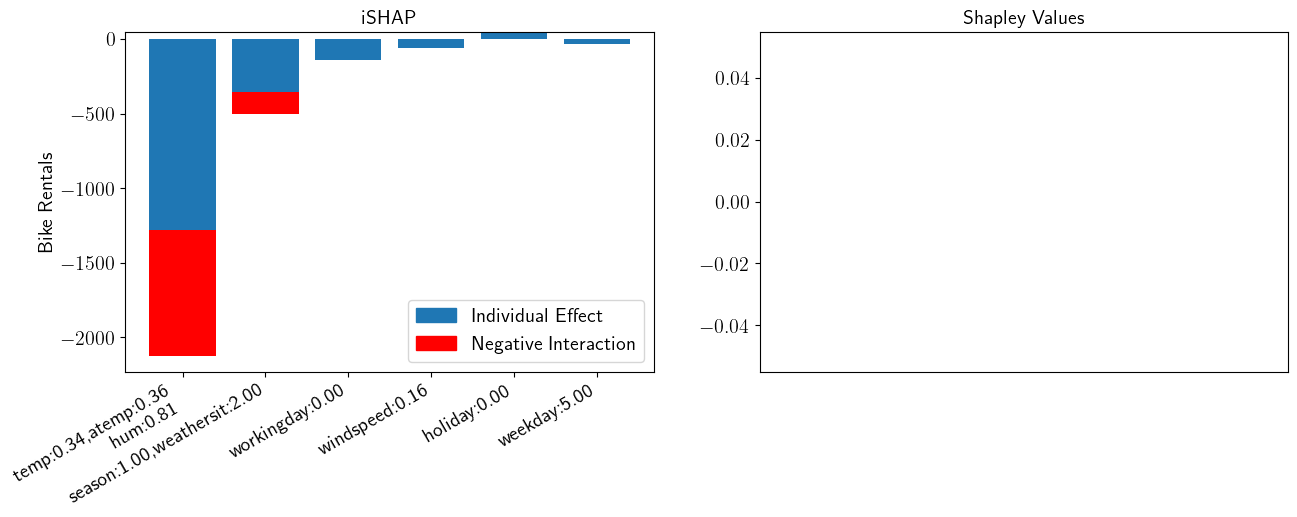

In [4]:
# we provide a function to visualize the explanation

shapley_values = compute_coalition_shapleys([(i,) for i in range(len(instance))],model,instance,X,is_classification=classification,sampling_method="marginal",n_samples=10000)

pandas_instance = dataset["df"].iloc[0,:]#.drop("group")
feature_names = dataset["feature_names"]

# use individual value functions as reference
single_values = compute_singleton_values(model,instance,X,is_classification=classification,sampling_method="marginal",n_samples=2000)

_, axs = plt.subplots(1,2,figsize=(15,5))
plot_ishap(explanation,single_values,pandas_instance,fx,feature_names,ylabel="",title="iSHAP",ax=axs[0])
axs[0].set_ylabel("Bike Rentals")

plot_shapley(feature_names,pandas_instance,shapley_values,title="Shapley Values",ax=axs[1])
axs[0].set_ylabel("Bike Rentals")



## Obtained explanation
The *iSHAP* explanation is plotted on the left. Because it is a cold Friday in winter (Weekday:5, Season:1, Temp: 0.34) and a rainy cold day (weathersit:2, atemp: 0.36, hum:0.81), the model predicts that fewer bikes will be rented. This provides further information beyond the purely singleton explanation by SHAP on the right. 

## Interaction Graph
Furthermore, the results of the interaction test provide further information about pairwise relationships that are picked up the model. The code provides a function to visualize the graph returned by the ishap function. Cold weather in winter, as well as the interaction of low felt temperature with high humidity which indicates rain are marked negatively. 

Coalition Set | Individual Effect | Interaction Effect
--------------|-------------------|-------------------
weekday:5.00,season:1.00,temp:0.34 |              6.46 |           -482.84
weathersit:2.00,atemp:0.36,hum:0.81 |             30.54 |           -553.58
workingday:0.00 |             19.38 |           -128.41
mnth:1.00     |           -123.20 |            195.31
windspeed:0.16 |             35.81 |              9.65
holiday:0.00  |            -26.56 |             40.78


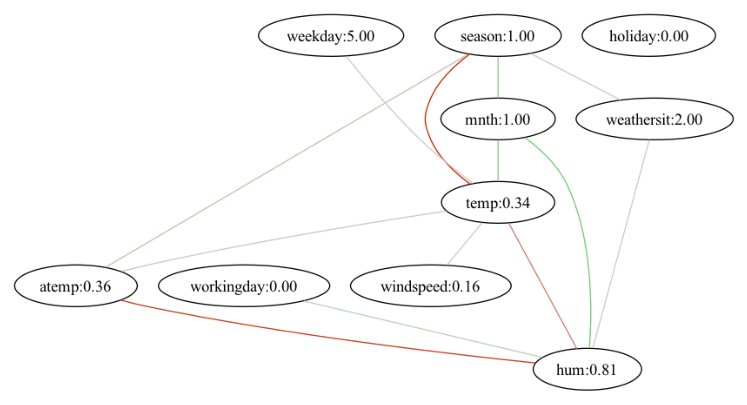

In [46]:
show_interaction_graph(interactions,feature_names,instance,pandas_instance,model, X,average_pred,classification,"marginal",2000)

coalition_sets = list(map(lambda x: x[0], explanation))
values_coalitions = list(map(lambda x: x[1], explanation))
order = np.argsort(np.abs(values_coalitions))[::-1]
values_coalitions = np.array(values_coalitions)[order]
coalition_sets = [coalition_sets[i] for i in order]
interaction_effects = []
values_singletons = np.array(list(map(lambda x: x[1], single_values)))
pandas_instance = list(map(lambda x: x if type(x)==str else "{:.2f}".format(x), pandas_instance))
coalitions = list(map(lambda x: list(map(lambda y: feature_names[y] + ":" + pandas_instance[y], x)), coalition_sets))
for i in range(len(coalition_sets)):
        coalition = list(coalition_sets[i])
        interaction_effects.append(values_coalitions[i] - np.sum(values_singletons[coalition]))
coalitions = list(map(lambda x: ",".join(x), coalitions))
print("Coalition Set | Individual Effect | Interaction Effect")
print("--------------|-------------------|-------------------")
for i in range(len(coalitions)):
    print("{:<13} | {:>17.2f} | {:>17.2f}".format(coalitions[i], values_singletons[coalition_sets[i][0]], interaction_effects[i]))